In [1]:
import sys
import time
import torch
from torch.utils.data import TensorDataset
import numpy as np
from matplotlib import pyplot as plt
import logging

sys.path.append("../../")
import manifold_flow as mf
from manifold_flow import transforms, utils, flows, distributions, training, timer
from manifold_flow import nn as nn_

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Timing function

In [2]:
def make_data(dim, n=100):
    return torch.randn(dim*n).view(n, dim)

In [3]:
def make_model(xdim, blocks=5, ldim=1):
    trf = flows.vector_transforms.create_transform(
        dim=xdim,
        flow_steps=5,
        linear_transform_type="permutation",
        base_transform_type="affine-coupling",
        hidden_features=20,
        num_transform_blocks=blocks,
        dropout_probability=0.,
        use_batch_norm=False
    )
    return trf

In [4]:
def time_logdet(model, data, repeats=3):
    times = []
    for _ in range(repeats):
        time_before = time.time()
        
        _ = model(data, full_jacobian=False)
        
        time_after = time.time()
        
        print(time_after-time_before, "s")
        times.append(time_after-time_before)
    return np.mean(times), np.std(times)

In [5]:
def time_jacobian(model, data, repeats=3):
    times = []
    for _ in range(repeats):
        # timer.reset()
        time_before = time.time()
        
        _ = model(data, full_jacobian=True)
        
        time_after = time.time()
        # timer.report()
        
        print(time_after-time_before, "s")
        times.append(time_after-time_before)
    return np.mean(times), np.std(times)

In [6]:
def run(xdim, blocks=5, jacobian=True):
    data = make_data(xdim)
    data.requires_grad = True
    model = make_model(xdim, blocks)
    if jacobian:
        return time_jacobian(model, data)
    else:
        return time_logdet(model, data)

## Go!

In [7]:
blocks = [1,2,5,10]
xdims = [2,5,10,20,50,100]

jacobian_means = []
jacobian_stds = []
det_means = []
det_stds = []

for block in blocks:
    for xdim in xdims:
        print("blocks = {}, xdim = {}".format(block, xdim))
        mean_jac, std_jac = run(xdim, block, True)
        mean_det, std_det = run(xdim, block, False)
        jacobian_means.append(mean_jac)
        jacobian_stds.append(std_jac)
        det_means.append(mean_det)
        det_stds.append(std_det)

blocks = np.asarray(blocks)
xdims = np.asarray(xdims)
jacobian_means = np.asarray(jacobian_means).reshape(len(blocks), -1)
jacobian_stds = np.asarray(jacobian_stds).reshape(len(blocks), -1)
det_means = np.asarray(det_means).reshape(len(blocks), -1)
det_stds = np.asarray(det_stds).reshape(len(blocks), -1)


blocks = 1, xdim = 2
0.28333377838134766 s
0.27977490425109863 s
0.27565598487854004 s
0.0016772747039794922 s
0.001953125 s
0.0019371509552001953 s
blocks = 1, xdim = 5
0.7183878421783447 s
0.698451042175293 s
0.7067008018493652 s
0.0019218921661376953 s
0.0021369457244873047 s
0.002756834030151367 s
blocks = 1, xdim = 10
1.398780107498169 s
1.449267864227295 s
1.3687210083007812 s
0.002629995346069336 s
0.0028781890869140625 s
0.002138853073120117 s
blocks = 1, xdim = 20
2.8895978927612305 s
2.8667099475860596 s
2.936685085296631 s
0.002960681915283203 s
0.0031349658966064453 s
0.002390623092651367 s
blocks = 1, xdim = 50
8.74571704864502 s
8.031109094619751 s
8.011993885040283 s
0.003422975540161133 s
0.0034859180450439453 s
0.0032091140747070312 s
blocks = 1, xdim = 100
19.990101099014282 s
20.559340000152588 s
19.982884168624878 s
0.009060144424438477 s
0.006200075149536133 s
0.005620002746582031 s
blocks = 2, xdim = 2
0.31042003631591797 s
0.3117659091949463 s
0.3120870590209961 

## Plot

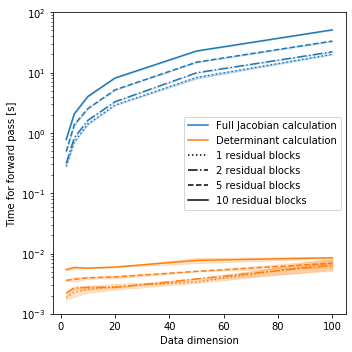

In [9]:
linestyles = [":", "-.", "--", "-"]
fig = plt.figure(figsize=(5,5))

for i, (block, ls) in enumerate(zip(blocks, linestyles)):
    plt.fill_between(xdims, jacobian_means[i] - jacobian_stds[i], jacobian_means[i]+jacobian_stds[i], color="C0", alpha=0.2)
    plt.plot(xdims, jacobian_means[i], c="C0", ls=ls)
    
    plt.fill_between(xdims, det_means[i] - det_stds[i], det_means[i]+det_stds[i], color="C1", alpha=0.2)
    plt.plot(xdims, det_means[i], c="C1", ls=ls)
    
plt.plot([], [], c="C0", ls="-", label="Full Jacobian calculation")
plt.plot([], [], c="C1", ls="-", label="Determinant calculation")
plt.plot([], [], c="black", ls=":", label="1 residual blocks")
plt.plot([], [], c="black", ls="-.", label="2 residual blocks")
plt.plot([], [], c="black", ls="--", label="5 residual blocks")
plt.plot([], [], c="black", ls="-", label="10 residual blocks")
plt.legend()

plt.xlabel("Data dimension")
plt.ylabel("Time for forward pass [s]")
plt.ylim(1.e-3,1.e2)
plt.yscale("log")
# plt.ylim(0.,None)

plt.tight_layout()
plt.savefig("manifold_flow_timing_log.pdf")
